In [1]:
#import libraries 
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium

#### Let's load the neighborhoods data and look at the first few rows
(https://data.nashville.gov/Metro-Government/Neighborhood-Association-Boundaries-GIS-/qytv-2cu8)


In [2]:
neighborhoods = gpd.read_file('./data/Zip Codes (GIS).geojson')
neighborhoods.head(1)

,zip,objectid,po_name,shape_stlength,shape_starea,geometry
0,37027,34,BRENTWOOD,3140.581074908484,595244.46435546875,"(POLYGON ((-86.684745973484 35.992792089723, -..."


#### Plotting a GeoDataFrame is as easy as calling the GeoPandas .plot() function


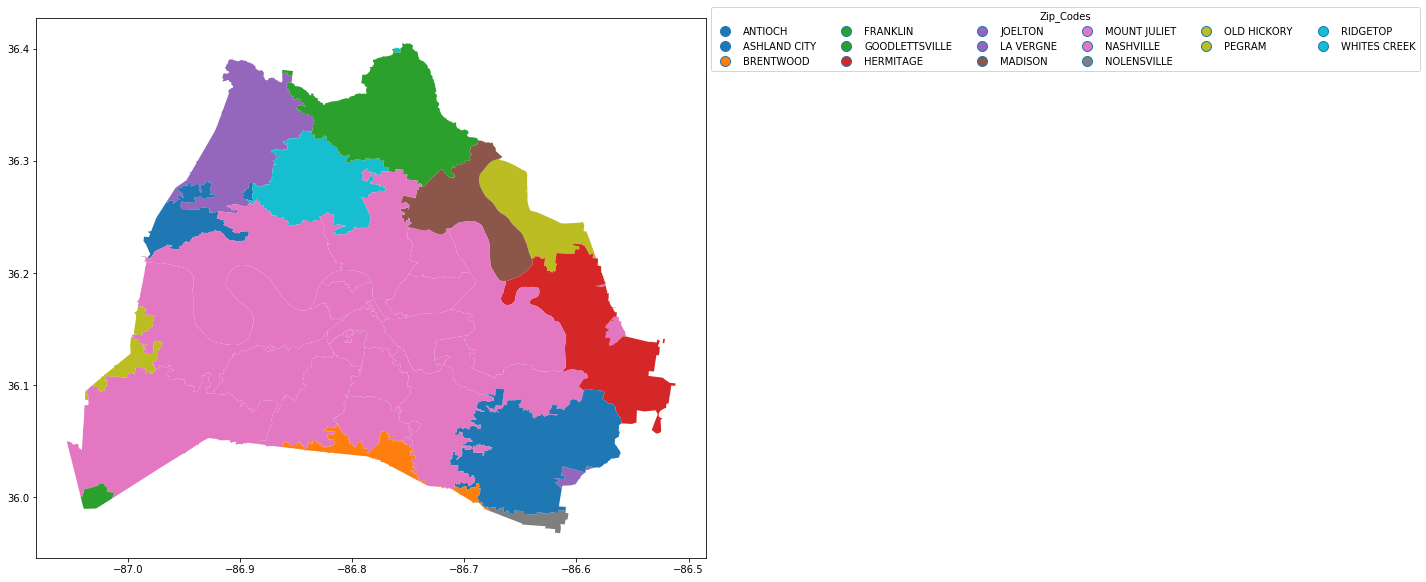

In [3]:
#geopandas handles legend styling if you pass a dict of keywords
leg_kwds = {'title': 'Zip_Codes', 'loc': 'upper left', 'bbox_to_anchor': (1, 1.03), 'ncol': 6}
neighborhoods.plot(column = 'po_name', figsize=(12, 12), legend = True, legend_kwds = leg_kwds)
plt.show()

#### Public Works in Nashville


In [4]:
pw = pd.read_csv('./data/Metro_Public_Works_Capital_Projects.csv')
pw.head()

,CP ID,Project Number,Project Category,Project Type,Project Name,Project Location,Description,Justification,Council District,Plan Cost,...,Project SubType,Priority,Phase,PPA Number,x Coordinate,y Coordinate,Latitude,Longitude,Map URL,Mapped Location
0,5274,NaN,Traffic,New Traffic Signal,Metro Fire Station No 19 - Traffic Signal,AT CHARLOTTE AVE AND 26TH AVENUE NORTH,Install/modify intersection control features,To provide traffic control features that will ...,21,5936.00,...,New,Medium,Complete,130-03016,1.727710e+06,663933.196954,36.154530,-86.815630,<a href='https://mpw.nashville.gov/CapitalProj...,"(36.15452982, -86.81562974)"
1,53,NaN,Sidewalk,Sidewalk Repairs,Woodland Street Sidewalk Repairs,Woodland Street from South 2nd Street to Inter...,Sidewalk repairs,To provide safer pedestrian access to nearby b...,06,45053.00,...,Maintenance/Repairs,Medium,Complete,98-01016,1.741303e+06,669479.220891,36.170067,-86.769735,<a href='https://mpw.nashville.gov/CapitalProj...,"(36.17006717, -86.76973504)"
2,5369,NaN,Bikeway,NaN,Music Row E From 16th Ave S To Buddy Killen Cir,On Music Row E From 16th Ave S To Buddy Killen...,New protected bike lane,"To provide safer cyclist route, connectivity t...",19,44700.00,...,New,Medium,Complete,1058-03013,1.734505e+06,661045.920654,36.146759,-86.792541,<a href='https://mpw.nashville.gov/CapitalProj...,"(36.14675893, -86.79254128)"
3,146,NaN,Bikeway,Protected Bike Lane,28th Avenue North,28th Avenue North from Charlotte Avenue to Par...,New Protected Bike Lane,"To provide safer cyclist route, connectivity t...",21,0.00,...,New,Medium,Complete,899-03014,1.726708e+06,662949.225246,36.151770,-86.819027,<a href='https://mpw.nashville.gov/CapitalProj...,"(36.15177019, -86.81902664)"
4,5179,NaN,Bridge,Maintenance and Repair Jobs,Cheyenne Boulevard,On CHEYENNE BLVD Between CHEYENNE TRCE And CAN...,Repair damaged handrail,Repair handrail to ensure safe passage of pede...,09,7843.32,...,Maintenance/Repairs,Medium,Complete,257-02015,1.770788e+06,698568.691712,36.250568,-86.670521,<a href='https://mpw.nashville.gov/CapitalProj...,"(36.25056779, -86.67052115)"


In [5]:
print(pw.columns)

Index(['CP ID', 'Project Number', 'Project Category', 'Project Type',
       'Project Name', 'Project Location', 'Description', 'Justification',
       'Council District', 'Plan Cost', 'Estimated Cost', 'Actual Cost',
       'Project Cost', 'Percent Spent', 'Estimated Start', 'Estimated End',
       'Actual Start', 'Actual End', 'Status', 'Notes', 'Project SubType',
       'Priority', 'Phase', 'PPA Number', 'x Coordinate', 'y Coordinate',
       'Latitude', 'Longitude', 'Map URL', 'Mapped Location'],
      dtype='object')


#### We'll clean up the column names so they don't have spaces, and then use a lambda expression with shapely Point to create a geometry field in the art DataFrame

In [6]:
pw.columns = ['CP_ID', 'Project_Number', 'Project_Category', 'Project_Type',
       'Project_Name', 'Project_Location', 'Description', 'Justification',
       'Council_District', 'Plan_Cost', 'Estimated_Cost', 'Actual_Cost',
       'Project_Cost', 'Percent_Spent', 'Estimated_Start', 'Estimated_End',
       'Actual_Start', 'Actual_End', 'Status', 'Notes', 'Project_SubType',
       'Priority', 'Phase', 'PPA Number', 'x Coordinate', 'y Coordinate',
       'lat', 'lng', 'Map_URL', 'loc']
pw['geometry'] = pw.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)

In [7]:
pw.Project_Category.unique()

array(['Traffic', 'Sidewalk', 'Bikeway', 'Bridge', 'Paving', 'Culvert',
       'Guardrail', 'Capital'], dtype=object)

In [8]:
pw[['Project_Category', 'CP_ID']].groupby('Project_Category').agg('count').sort_values(by ='CP_ID', ascending = False)

,CP_ID
Project_Category,
Paving,832
Bridge,401
Bikeway,164
Sidewalk,123
Culvert,74
Traffic,64
Capital,8
Guardrail,7


#### Now that art has a geometry field, we can convert it from a DataFrame to a GeoDataFrame - we want the CRS to match the CRS in the neighborhoods GeoDataFrame so we set it to that

In [9]:
pw_geo = gpd.GeoDataFrame(pw, crs = neighborhoods.crs, geometry = pw['geometry'])

#### Now we're ready to combine the neighborhoods and the art with a spatial join


In [10]:
neighborhood_pw = gpd.sjoin(pw_geo, neighborhoods, op = 'within')

#### Now that the data is joined spatially we can aggregate the art by neighborhood and see how many artworks are within each polygon

In [11]:
neighborhood_pw[['po_name','zip', 'CP_ID']].groupby(['po_name','zip']).agg('count').sort_values(by ='CP_ID', ascending = False)

CP_ID
po_name        zip         
ANTIOCH        37013    140
MADISON        37115    133
NASHVILLE      37211    133
               37221    123
               37209     98
               37207     91
               37203     74
HERMITAGE      37076     72
NASHVILLE      37205     68
               37214     67
               37212     64
               37218     63
               37217     63
GOODLETTSVILLE 37072     59
NASHVILLE      37210     48
               37216     47
               37208     46
               37206     45
BRENTWOOD      37027     35
NASHVILLE      37215     33
WHITES CREEK   37189     31
NASHVILLE      37204     29
OLD HICKORY    37138     27
JOELTON        37080     23
NASHVILLE      37213     19
               37201     12
               37219      8
               37220      5
               37228      5
ASHLAND CITY   37015      2
MOUNT JULIET   37122      1
FRANKLIN       37064      1
NASHVILLE      37232      1
PEGRAM         37143      1

#### Subset the neighborhood_art to get only the art that is in the downtown 'Urban Residents' neighborhood

In [12]:
urban_pw1 = neighborhood_pw.loc[neighborhood_pw.po_name == 'Nashville']
urban_pw = urban_pw1.loc[urban_pw1.Project_Category == 'Traffic']
urban_pw.head()

,CP_ID,Project_Number,Project_Category,Project_Type,Project_Name,Project_Location,Description,Justification,Council_District,Plan_Cost,...,lng,Map_URL,loc,geometry,index_right,zip,objectid,po_name,shape_stlength,shape_starea


#### Get just the 'Urban Residents' polygon from the neighborhoods data and take a look at it

In [14]:
urban_polygon = neighborhoods.loc[neighborhoods.zip == '37211']
urban_polygon.head() 

,zip,objectid,po_name,shape_stlength,shape_starea,geometry
48,37211,47,NASHVILLE,291945.03008033131,603158707.04760742,"(POLYGON ((-86.756956838904 36.131885734303, -..."


#### Plot the Urban Residents Neighborhood and add our public art, coloring the points by the type of art.

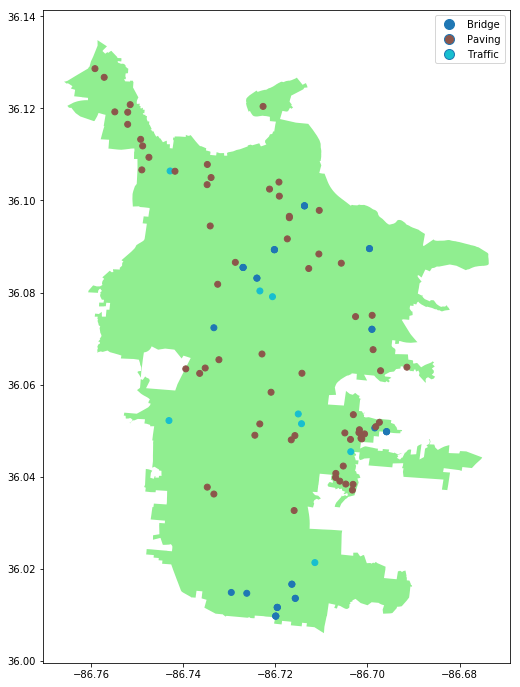

In [15]:
ax = urban_polygon.plot(figsize = (12, 12), color = 'lightgreen')
#ax is the area to use to show the plot
urban_pw.plot( ax = ax, column = 'Project_Category', legend = True);
#setting ax = ax means that we want to plot over the same area
plt.show();

#### We're getting there! It would be helpful to have streets, though wouldn't it? We can add a street map with the folium package.

#### Our folium map wants a center point for the street map. We'll make use of a GeoSeries attribute (.centroid) which gives us the center of a polygon.

In [16]:
#find the center of our urban_polygon and look at it
urban_polygon.geometry.centroid

48    POINT (-86.72310866739669 36.06704137683693)
dtype: object

#### The centroid is actually a pandas series; get the first element

In [17]:
# find the center of the urban polygon with the centroid property
center = urban_polygon.geometry.centroid

# get and store the first occurence which will be a Point geometry
center_point = center.iloc[0]

# print the types for center and center_point
print('center is :', type(center))
print('center_point is :', type(center_point))

center is : <class 'geopandas.geoseries.GeoSeries'>
center_point is : <class 'shapely.geometry.point.Point'>


#### Folium wants a location point as an array with *latitude* first, but shapely Points have *longitude* first

In [18]:
# center point has longitude first
print(center_point)

# reverse the order when constructing the array for folium location
urban_center = [center_point.y, center_point.x]

# check the order of urban_center, the location we'll set for our folium map
print(urban_center)

POINT (-86.72310866739669 36.06704137683693)
[36.06704137683693, -86.72310866739669]


#### Use `urban_center` as the `location` of the folium map. A zoom level of 15 should get us nice and close.

In [19]:
#create our map of Nashville and show it
map_downtown = folium.Map(location =  urban_center, zoom_start = 11)
map_downtown

#### Next, let's add our Urban Residents neighborhood polygon and art markers.

#### `itterows()` is a generator that iterates through the rows of a DataFrame and returns a tuple with the row id and row values. Below, we are printing the row values for each row as we iterate through the GeoDataFrame of urban art. This idea will be helpful for creating our markers!

In [20]:
for row in urban_pw.iterrows():
    row_values = row[1]
    print(row_values)

CP_ID                                                            2427
Project_Number                                                    NaN
Project_Category                                               Bridge
Project_Type                             Cut Vegetation/Remove Debris
Project_Name                                         Paragon Mills Rd
Project_Location    Paragon Mills Rd/ Branch between Vally Ridge D...
Description                                         Remove vegetation
Justification       To repair the jobs identified by customer serv...
Council_District                                                   26
Plan_Cost                                                        3658
Estimated_Cost                                                   3658
Actual_Cost                                                      2454
Project_Cost                                                     2454
Percent_Spent                                                    100%
Estimated_Start     

CP_ID                                                            1104
Project_Number                                               PV-10157
Project_Category                                               Paving
Project_Type                                                   Paving
Project_Name                  LANDERS AVE - MCCLAIN AVE - THOMPSON LN
Project_Location              LANDERS AVE - MCCLAIN AVE - THOMPSON LN
Description         Paving Project: LANDERS AVE - MCCLAIN AVE - TH...
Justification                                   Paving Project Needed
Council_District                                                   16
Plan_Cost                                                       18700
Estimated_Cost                                                      0
Actual_Cost                                                   22577.2
Project_Cost                                                  22577.2
Percent_Spent                                                    100%
Estimated_Start     

CP_ID                                                            2022
Project_Number                                               PV-11266
Project_Category                                               Paving
Project_Type                                                   Paving
Project_Name                 ILAWOOD DR - CEDARMONT CR - CEDARVIEW DR
Project_Location             ILAWOOD DR - CEDARMONT CR - CEDARVIEW DR
Description         Paving Project: ILAWOOD DR - CEDARMONT CR - CE...
Justification                                   Paving Project Needed
Council_District                                                   31
Plan_Cost                                                       50150
Estimated_Cost                                                  46131
Actual_Cost                                                   49349.4
Project_Cost                                                  49349.4
Percent_Spent                                                    100%
Estimated_Start     

CP_ID                                                            1268
Project_Number                                             19SUM11163
Project_Category                                               Paving
Project_Type                                               19SUM11163
Project_Name                  BENITA DR - PARAGON MILLS RD - DEAD END
Project_Location              BENITA DR - PARAGON MILLS RD - DEAD END
Description         PAVING PROJECT: BENITA DR - PARAGON MILLS RD -...
Justification                                   PAVING PROJECT NEEDED
Council_District                                                   26
Plan_Cost                                                      101348
Estimated_Cost                                                86320.9
Actual_Cost                                                         0
Project_Cost                                                  86320.9
Percent_Spent                                                      0%
Estimated_Start     

#### The map of Nashville (`map_downtown`) has already been created.
* add the downtown neighborhood outline (urban_polygon)
* iterate through the urban art to
    * create location from each lat and lng
    * create a popup from title and type
    * build a marker from each location and popup
    * add the marker to  `map_downtown`
* display `map_downtown`

In [20]:
#draw our neighborhood: Urban Residents
folium.GeoJson(urban_polygon).add_to(map_downtown)

#iterate through our urban art to create locations and markers for each piece
#here lat is listed first!!
#also the apostrophe in the 4th row causes problems!

for row in urban_pw.iterrows():
    row_values = row[1] 
    location = [row_values['lat'], row_values['lng']]
  #  popup = (str(row_values['title']) + ': ' + 
  #           str(row_values['type']) + '<br/>' +
  #           str(row_values['desc'])).replace("'", "`")
    marker = folium.Marker(location = location)#, popup = popup)
    
    marker.add_to(map_downtown)

#display our map
map_downtown